# Look at the overview scans
Let's see what we did there.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
client = Client()
# Then go to http://localhost:8787/status
from numcodecs import Blosc
import skimage
from tqdm import notebook

In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [3]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'EAWAG')
print('We are loading all the data from %s' % Root)

We are loading all the data from D:\Results\EAWAG


In [8]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [9]:
def get_projectionsize(logfile):
    """How big did we set the camera?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Number Of Rows' in line:
                y = int(line.split('=')[1])
            if 'Number Of Columns' in line:
                x = int(line.split('=')[1])                
    return(x*y)

In [10]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [11]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [12]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [13]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [14]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [15]:
def get_scantime(logfile):
    """How long did we scan?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scan duration' in line:
                time = line.split('=')[1].strip()
    return(pandas.to_timedelta(time))

In [16]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [17]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [18]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [19]:
# Get all folders
Data['Folder'] = glob.glob(os.path.join(Root, '*'))

In [20]:
# Get rid of all non-folders
for c, i in Data.iterrows():
    if not os.path.isdir(i.Folder):
        Data.drop([c], inplace=True)

In [21]:
Data['Sample'] = [os.path.basename(f) for f in Data['Folder']]
Data['SampleNameLength'] = [len(r) for r in Data['Sample']]

In [22]:
# Get all log files
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.log'))) for f in Data['Folder']]

In [23]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, 'rec', '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [24]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for sample in Data[Data['Number of reconstructions'] == 0]['Sample']:
    print('%s has not been reconstructed yet, we remove it from our data temporarily' % sample)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s fish folders with reconstructions' % (len(Data)))

Teeth has not been reconstructed yet, we remove it from our data temporarily
TJ3 has not been reconstructed yet, we remove it from our data temporarily
TJ6 has not been reconstructed yet, we remove it from our data temporarily
We have 10 fish folders with reconstructions


In [25]:
# Get only main log file and voxel size
Data['LogFile'] = [l[0] for l in Data.LogFile]

In [26]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [get_projectionsize(log) for log in Data['LogFile']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]
Data['Scan time'] = [get_scantime(log) for log in Data['LogFile']]

In [27]:
# https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/
columns = list(Data)
columns.remove('Folder') 
columns.remove('Sample')
columns.remove('SampleNameLength')
columns.remove('LogFile')
columns.remove('Reconstructions')
columns.remove('Number of reconstructions')
columns.remove('Grayvalue')
columns.remove('Scan time')
print(columns)
for col in columns:
    print(col)
    print(Data[col].unique())
    print(80*'-')    

['Voxelsize', 'Filter', 'Exposuretime', 'ProjectionSize', 'RingartefactCorrection', 'BeamHardeningCorrection']
Voxelsize
[5.000018 5.000014 5.001124]
--------------------------------------------------------------------------------
Filter
['Al 0.5mm']
--------------------------------------------------------------------------------
Exposuretime
[3254 1162 2888]
--------------------------------------------------------------------------------
ProjectionSize
[16085120  4021280]
--------------------------------------------------------------------------------
RingartefactCorrection
[14  7 19]
--------------------------------------------------------------------------------
BeamHardeningCorrection
[0]
--------------------------------------------------------------------------------


In [28]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
roundto = 2
if len(Data['Voxelsize'].round(roundto).unique()) > 1:
    print('We scanned all datasets with %s different voxel sizes' % len(Data['Voxelsize'].round(roundto).unique()))
    for vs in sorted(Data['Voxelsize'].round(roundto).unique()):
        print('-', vs, 'um for Samples ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'], roundto):
                print(row.Sample, end=', ')
        print('')
else:
    print('We scanned all datasets with equal voxel size, namely %s um.' % float(Data['Voxelsize'].round(roundto).unique()))

We scanned all datasets with equal voxel size, namely 5.0 um.


In [29]:
if len(Data['Grayvalue'].unique()) > 1:
    print('We reconstructed the datasets with different maximum gray values, namely')
    for gv in Data['Grayvalue'].unique():
        print(gv, 'for Samples ', end='')
        for c, row in Data.iterrows():
            if float(gv) == row['Grayvalue']:
                print(row.Sample, end=', ')
        print('')
else:
    print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

We reconstructed the datasets with different maximum gray values, namely
0.103898 for Samples 103754, 
0.13 for Samples 103908, 
0.125004 for Samples 106985, 
0.089655 for Samples 14269, 
0.106857 for Samples 14298, 
0.100226 for Samples 21322, 
0.133082 for Samples IG96, 
0.11886 for Samples v1_103908, 
0.143809 for Samples v1_14295, 
0.118008 for Samples v1_TJ3, 


In [30]:
Data[['Sample', 'Voxelsize', 'ProjectionSize', 'Scan time', ]]

Sample  Voxelsize  ProjectionSize Scan time
0     103754   5.000018        16085120  08:00:09
1     103908   5.000014         4021280  01:35:47
2     106985   5.001124         4021280  06:58:04
3      14269   5.000018        16085120  08:05:18
4      14298   5.000018        16085120  08:00:47
5      21322   5.000014         4021280  00:34:11
6       IG96   5.000018        16085120  07:58:53
7  v1_103908   5.000014         4021280  01:35:36
8   v1_14295   5.000014         4021280  00:34:17
9     v1_TJ3   5.000014         4021280  00:34:25

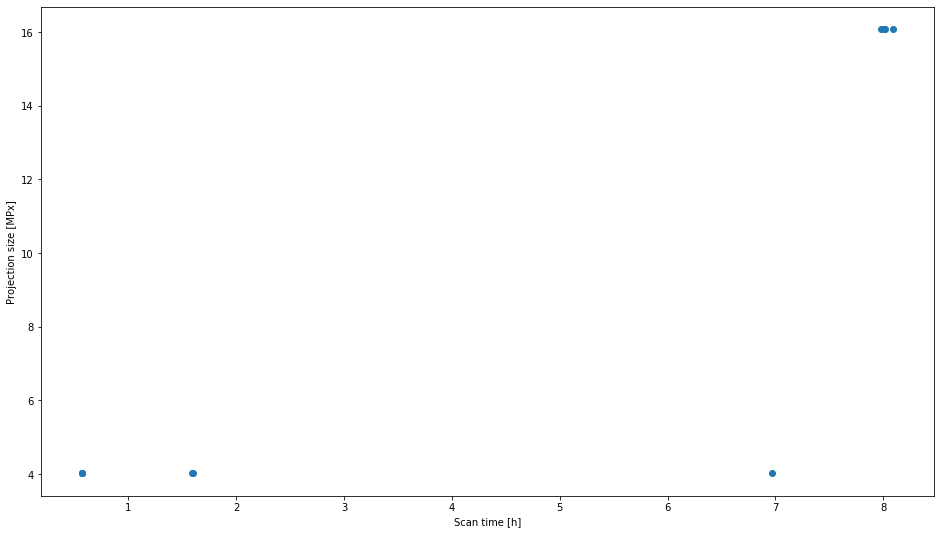

In [31]:
# Convert timedelta to minutes for plotting
# https://stackoverflow.com/a/54729327/323100
plt.scatter(x=Data['Scan time'].astype('timedelta64[s]') / 3600,
            y=Data['ProjectionSize']/1e6)
plt.ylabel('Projection size [MPx]')
plt.xlabel('Scan time [h]')
plt.show()

In [32]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, 'rec', '*_spr.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100, c, row100)) for pip in Data['PreviewImagePath']]

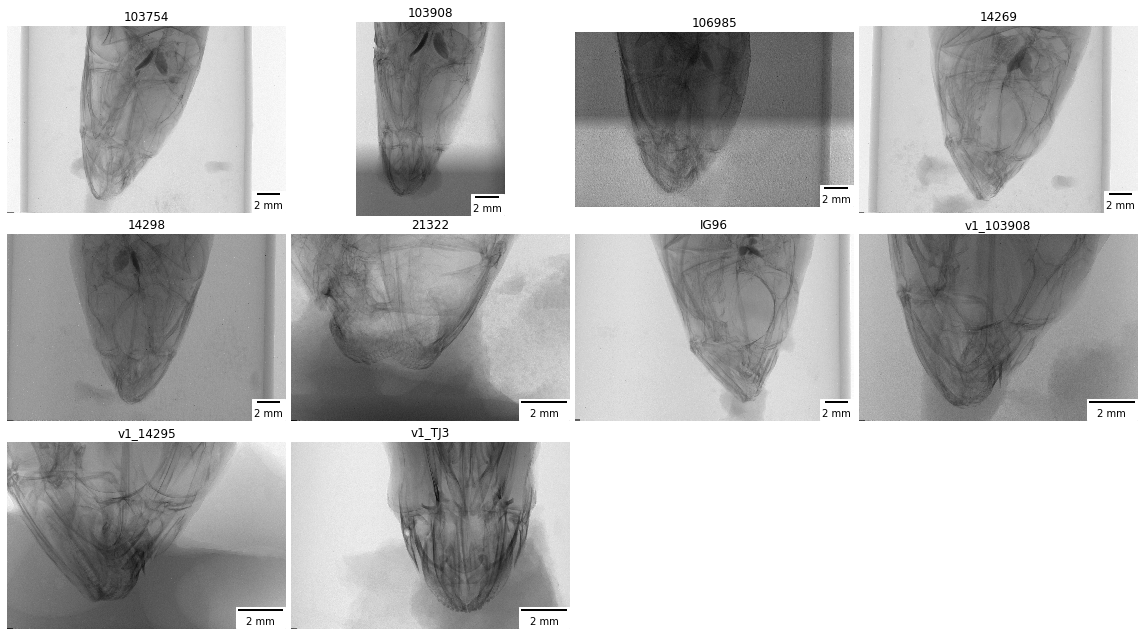

In [33]:
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title('%s' % row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                  'um',
                                  color='black',
                                  frameon=True))
    plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=0.5)
# plt.savefig(os.path.join(OutPutDir, 'ScanOverviews.png'),
#             bbox_inches='tight')
plt.show()

In [34]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%2s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root)+1:]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], 'rec', '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

In [35]:
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [36]:
# Load the reconstructions as zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [37]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [38]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [39]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

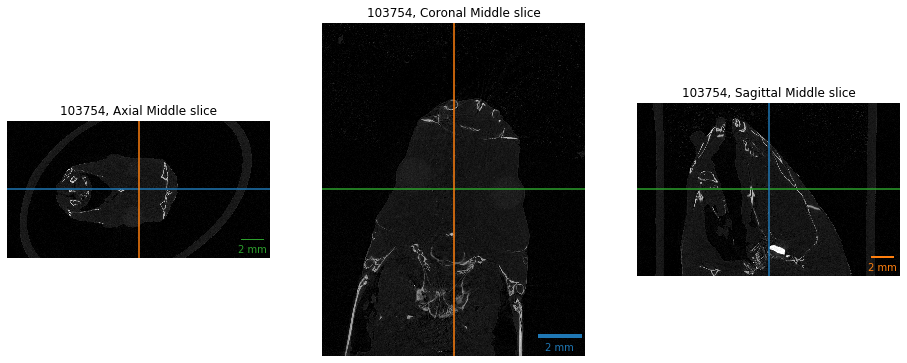

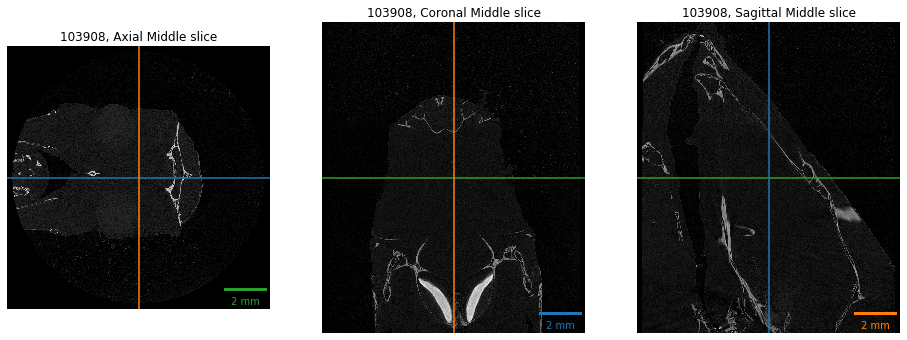

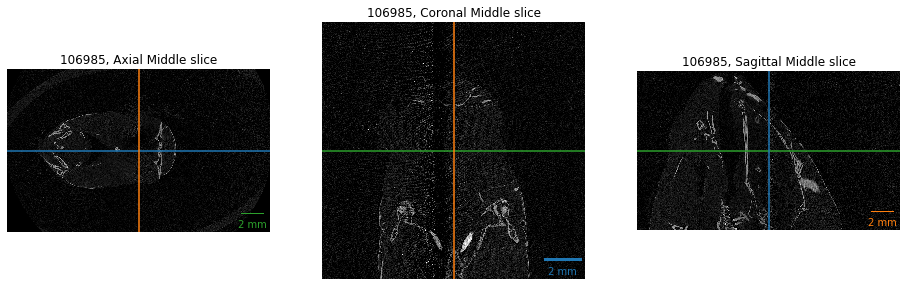

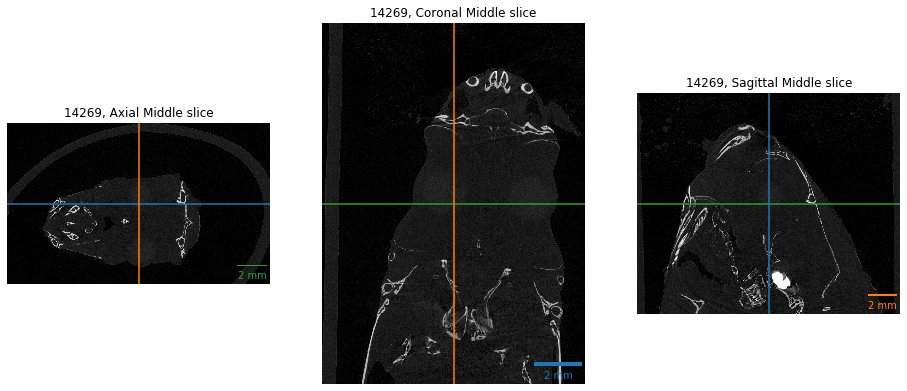

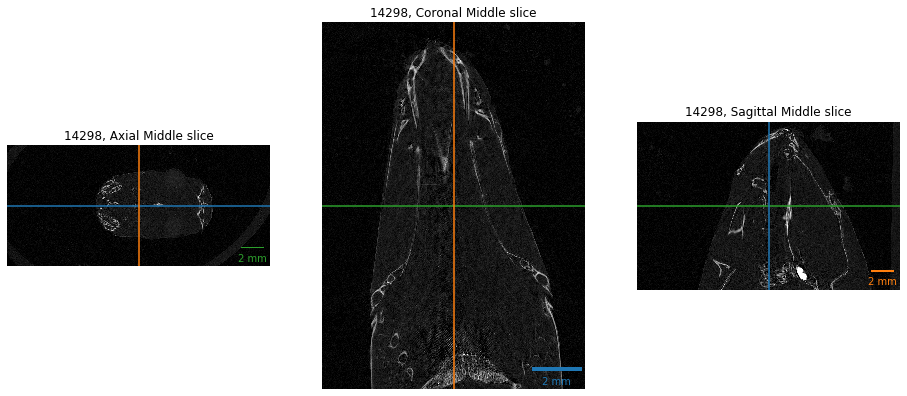

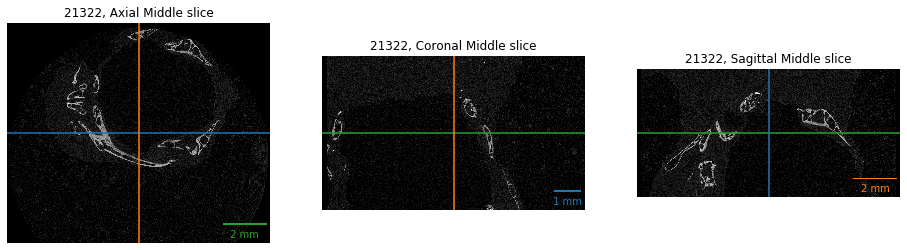

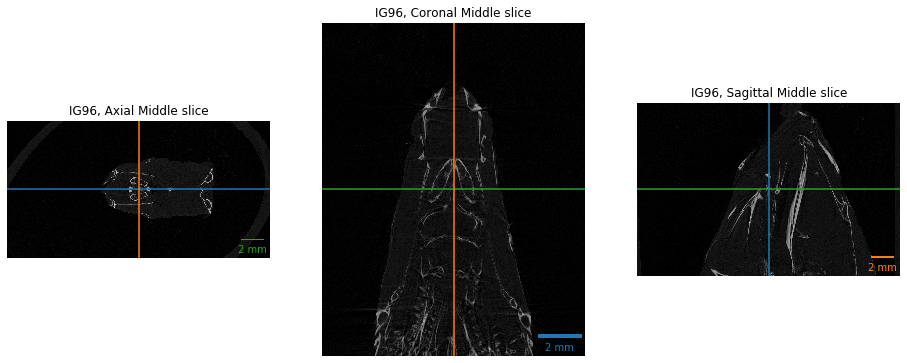

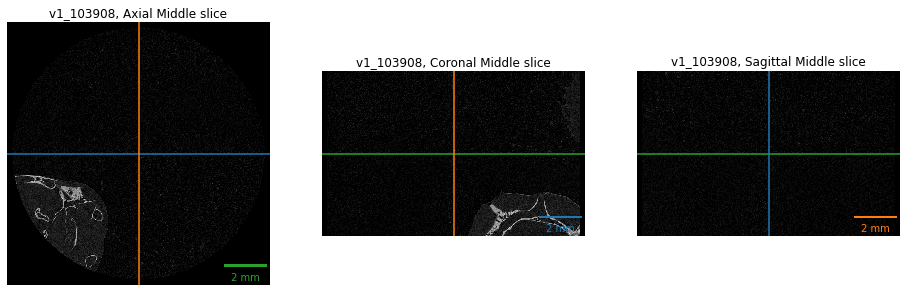

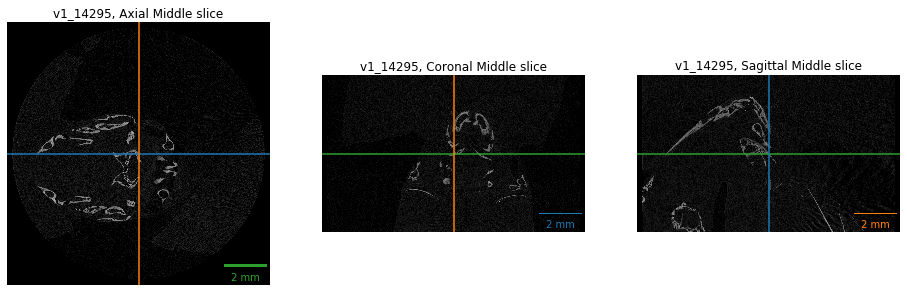

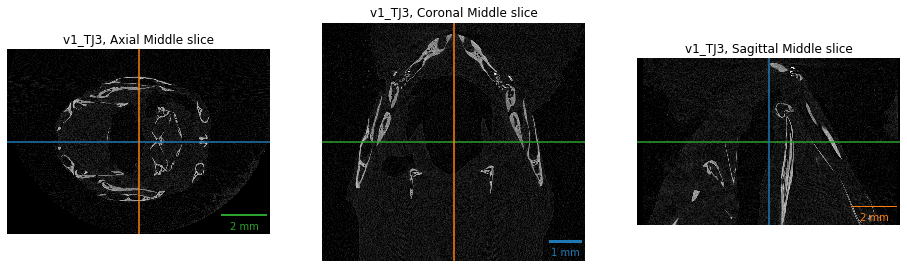

In [40]:
# Show middle slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png')
#     if not os.path.exists(outfilepath):    
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        if d == 0:
            plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
            plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um',
                                          color=seaborn.color_palette()[2]))
        elif d == 1:
            plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
            plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[1])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um',
                                          color=seaborn.color_palette()[0]))
        else:
            plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
            plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[0])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um',
                                          color=seaborn.color_palette()[1]))
        plt.title('%s, %s' % (row['Sample'],
                              direction + ' Middle slice'))
        plt.axis('off')
        plt.savefig(outfilepath,
                    transparent=True,
                    bbox_inches='tight')
    plt.show()

In [41]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='%s' % row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

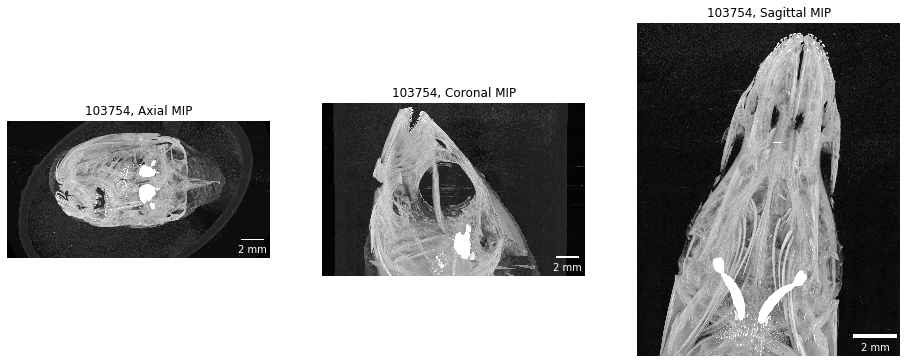

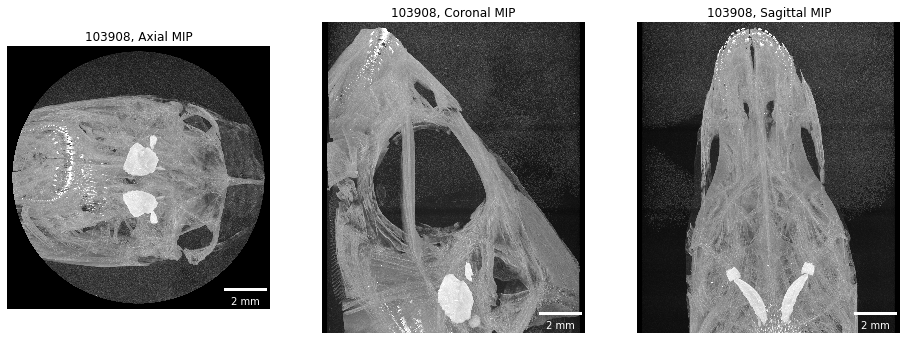

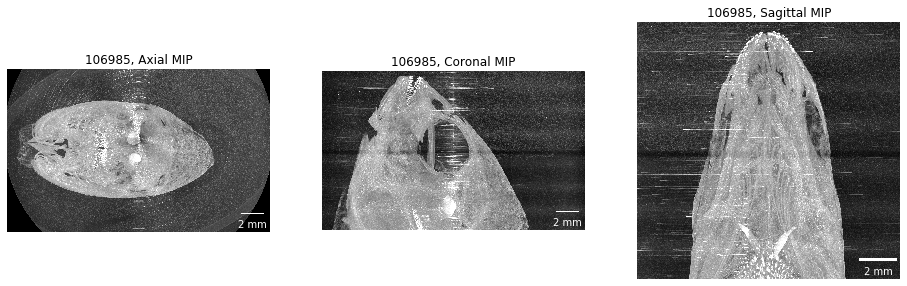

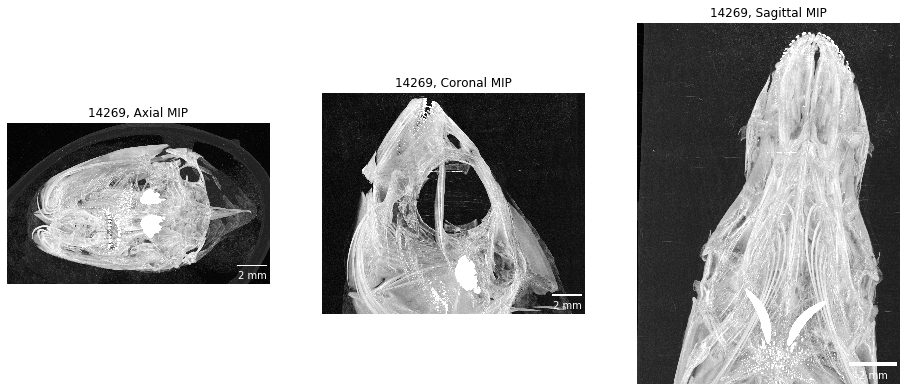

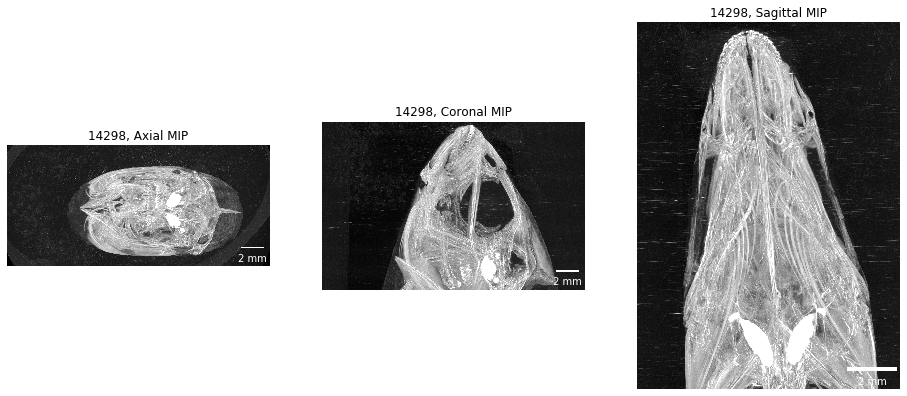

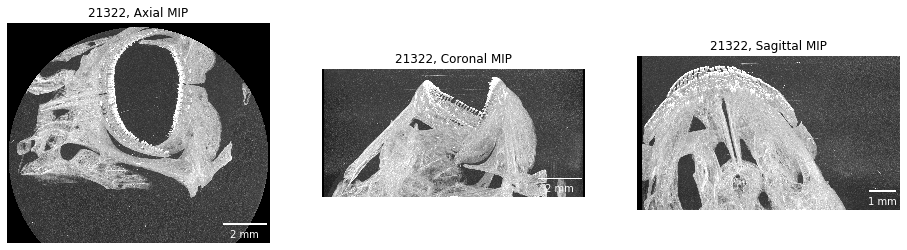

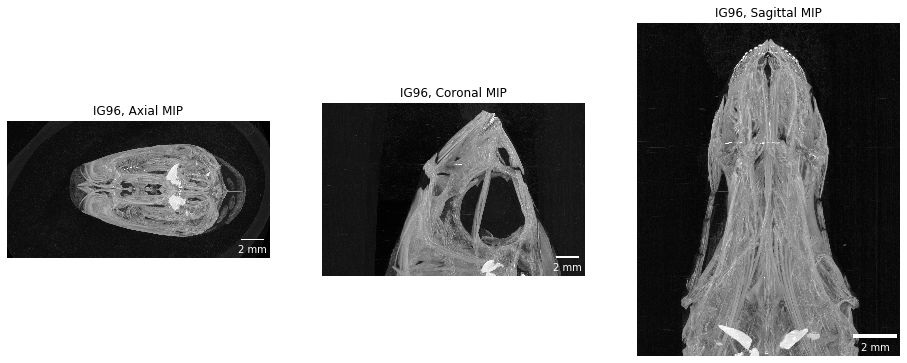

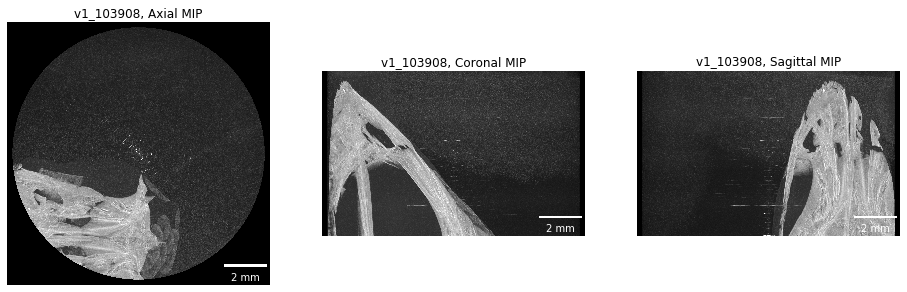

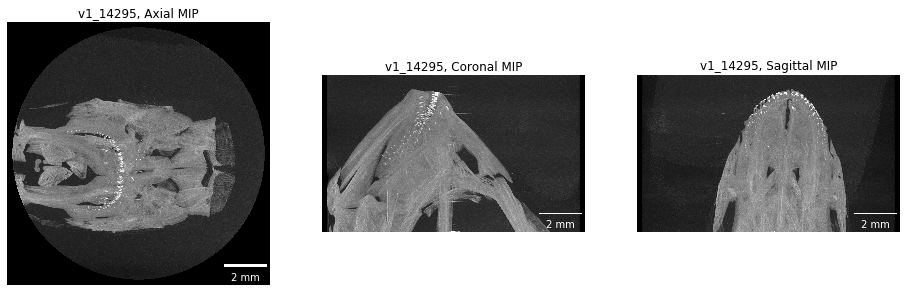

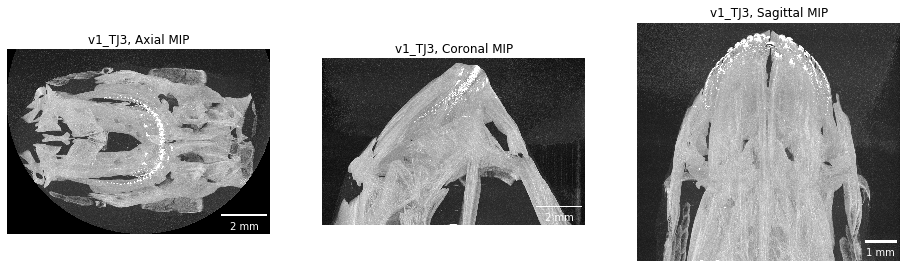

In [42]:
# Show MIP slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving MIP images overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.MIPs.png')
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                      'um'))
        plt.title('%s, %s' % (row['Sample'],
                              direction + ' MIP'))
        plt.axis('off')
    if not os.path.exists(outfilepath):
        plt.savefig(outfilepath,
                    transparent=True,
                    bbox_inches='tight')
    plt.show()